In [1]:
from keras.models import load_model
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math

Using TensorFlow backend.


In [2]:
model = load_model("model_0.h5")

In [3]:
with open('replays/ar1480052212-2187865278.hlt','r') as f:
    replay = json.load(f)

In [3]:
with open('../1482322937-875042713.hlt','r') as f:
    replay = json.load(f)

In [4]:
def draw_arrow(d,res=16):
    pattern = (0,0,0,1)
    if res!=16:
        raise Exception('Resolution must be 16')
    dot = np.zeros((16,16,4))
    arrow = np.zeros((16,16,4))
    arrow[7:9,2:14]=pattern
    arrow[6:10,12]=pattern
    arrow[5:11,11]=pattern
    arrow[4:12,10]=pattern
    if d == 1:
        return arrow.transpose((1,0,2))[::-1,:]
    elif d == 2:
        return arrow
    elif d == 3:
        return arrow.transpose((1,0,2))
    elif d == 4:
        return arrow[:,::-1]
    elif d == 0:
        return dot
    
arrows = {i:draw_arrow(i) for i in range(5)}

def grad_red(x):
    return (x,0,0,x)

def grad_black(x):
    return (1-x,1-x,1-x,x)

def int_col(x):
    d = {
        0:(0,0,0,1),
        1:(0,1,0,1),
        2:(0,0,1,1),
        3:(0,1,1,1),
        4:(0,0.5,1,1),
        5:(0,1,0.5,1),
        6:(0.2,0.7,1,1),
        7:(0.7,0.2,1,1),
    }
    return d[x]

def compute_im(mat,res=16,function=None,style='heat',cmap=grad_red):
    h = mat.shape[0]
    w = mat.shape[1]
    if function is None:
        function = lambda x:x if x is not None else 0
    im = np.zeros((h*res,w*res,4))
    qmap = {}
    vf = np.vectorize(function)
    
    qmap = vf(mat).astype(float)
    qmin,qmax = qmap.min(),qmap.max()
    
    for y in range(h):
        for x in range(w):
            if style == 'heat':
                im[y*res:y*res+res,x*res:x*res+res]=cmap((qmap[(y,x)]-qmin)/(qmax-qmin))
            elif style == 'colors':
                im[y*res:y*res+res,x*res:x*res+res]=cmap(qmap[(y,x)])
            elif style == 'squares':
                qnormed = (qmap[(y,x)]-qmin)/(qmax-qmin)
                square_size = qnormed*(res-2)+1
                start = int((res-square_size)/2)
                end = int((res-square_size)/2 + square_size)
                im[y*res+start:y*res+end,x*res+start:x*res+end]=(1,1,1,1)
            elif style == 'arrows':
                im[y*res:y*res+res,x*res:x*res+res]=arrows[int(qmap[(y,x)])]
    return im

def plot_im(im,alpha):
    plt.imshow(im,alpha=alpha)

def plot_ims(state=None):
    ims = []
    cmap_mapping = {
        'colors':int_col,
        'heat':grad_red
        
    }
    function_mapping = {
        'heat':lambda x:0. if x is None else x,
        'arrows': lambda x: 0. if x is None else x
    }
    alphas = [1.,1.,0.8,0.2]
    for k,v in state.items():
        ims.append(compute_im(v,style=k,cmap=cmap_mapping.get(k),function=function_mapping.get(k)))
    
    for im,alpha in zip(ims,alphas):
        if im is not None:
            plot_im(im,alpha=alpha)
    return ims

In [5]:
def get_frame(replay,step):
    frame = np.array(replay['frames'][step])
    prods = np.array(replay['productions'])
    return np.concatenate([frame,prods.reshape(prods.shape+(1,))],axis = 2)

def get_frames(replay):
    frames = np.array(replay['frames'])
    prods = np.repeat(np.array(replay['productions']).reshape((1,frames.shape[1],frames.shape[2],1)),frames.shape[0],axis=0)
    return np.concatenate([frames,prods],axis = 3)

def center_frame(frame,position,wrap_size=None):
    if not wrap_size:
        h = frame.shape[0]
        w = frame.shape[1]
    else:
        h,w = wrap_size
    return np.take(np.take(frame,
                np.arange(-int(h/2),int(h/2) + 1)+position[0],axis=0,mode='wrap'),
                np.arange(-int(w/2),int(w/2) + 1)+position[1],axis=1,mode='wrap')

def find_start(replay,player_id):
    frame = get_frame(replay,0)
    x,y = np.where(frame[:,:,0]==player_id)
    return (x[0],y[0])

def get_centroid_1D(X,L):
    n = len(X)
    mu_x = 1./n*sum([math.cos(x/float(L)*2*math.pi) for x in X])
    mu_y = 1./n*sum([math.sin(x/float(L)*2*math.pi) for x in X])
    if mu_x == 0:
        if mu_y > 0:
            return math.pi/2.
        else:
            return -math.pi/2.
    return int(round(L/math.pi/2.*math.atan2(mu_y,mu_x)%L))
    

def get_centroid(frame,player_id):
    X,Y = np.where(frame[:,:,0]==player_id)
    mX = get_centroid_1D(X,frame.shape[0])
    mY = get_centroid_1D(Y,frame.shape[1])
    return (mX,mY)

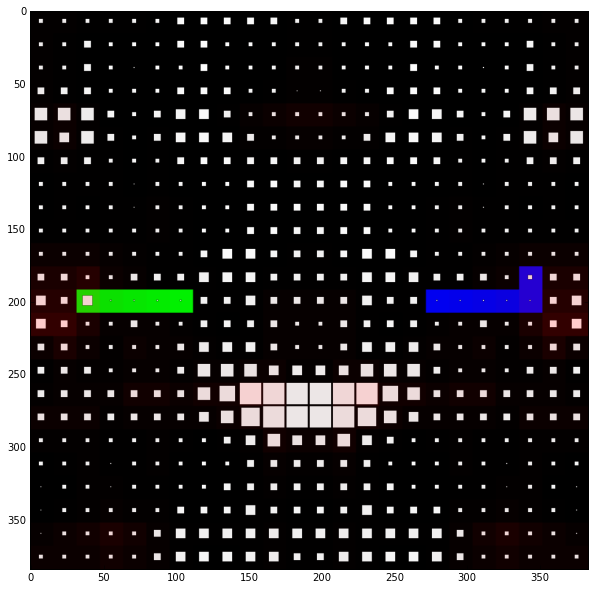

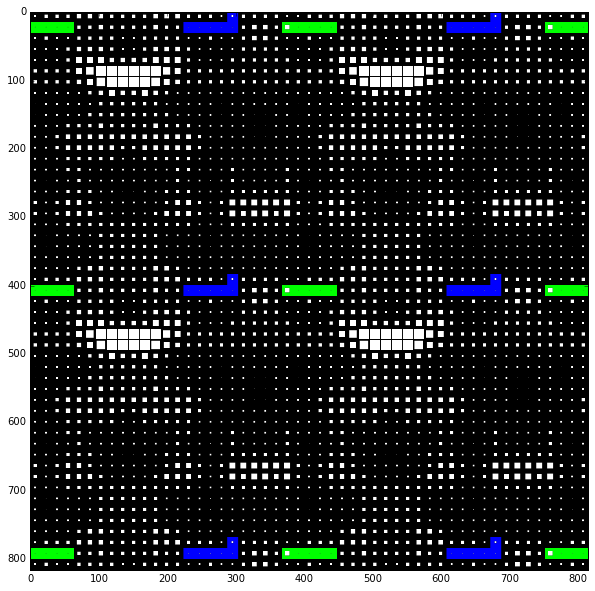

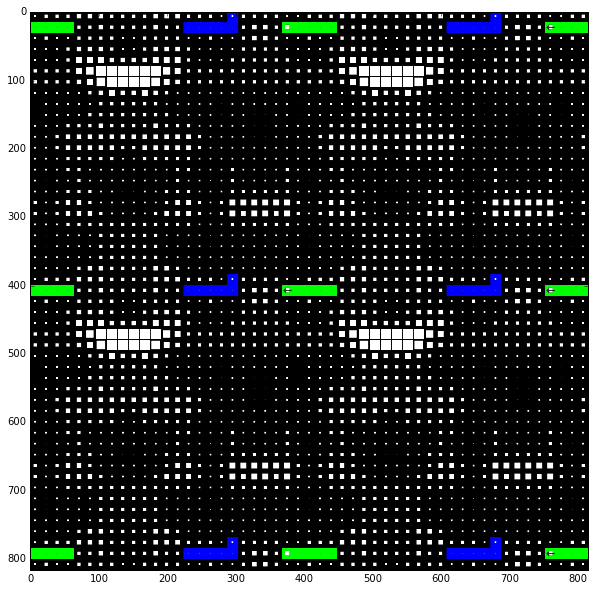

In [10]:
step = 20
target_id=1
wrap_shape = (51,51)

frames = get_frames(replay)
frame = frames[step]
moves = np.array(replay['moves'])
is_player = frames[:,:,:,0]==target_id
filtered_moves = np.where(is_player[:-1],moves,np.zeros_like(moves))

state = {
    'colors':frame[:,:,0],
    'heat':frame[:,:,2],
    'squares':frame[:,:,1],
    'arrows':filtered_moves[step]
}
plt.figure(figsize=(10,10))
ims = plot_ims(state)
plt.show()

centroid = get_centroid(frame,target_id)
new_frame = center_frame(frame,centroid,wrap_size=(51,51))

state = {
    'colors':new_frame[:,:,0],
    'squares':new_frame[:,:,1],
}

plt.figure(figsize=(10,10))
ims = plot_ims(state)
plt.show()


iframe = np.empty(shape=new_frame.shape[:2]+(4,))

iframe[:,:,0] = new_frame[:,:,0] == target_id
iframe[:,:,1] = (new_frame[:,:,0] != target_id) & (new_frame[:,:,0] != 0)
iframe[:,:,2] = new_frame[:,:,1]/20.
iframe[:,:,3] = new_frame[:,:,2]/255.


moves_pred = model.predict(np.array([iframe]))
moves_pred[:,:,:,0]/=2.

moves = np.argmax(moves_pred,axis=3)[0]

state = {
    'colors':new_frame[:,:,0],
    'squares':new_frame[:,:,1],
    'arrows':moves
}
plt.figure(figsize=(10,10))
ims = plot_ims(state)
plt.show()

In [9]:
moves_pred

array([[[[ -3.06974649e-01,   5.25402054e-02,   4.01327647e-02,
            1.85092539e-03,   1.37331598e-02],
         [ -2.24710345e-01,   4.74759713e-02,   4.37530950e-02,
            1.08104125e-02,   0.00000000e+00],
         [ -1.82940006e-01,   8.40300471e-02,   0.00000000e+00,
            1.45785548e-02,   0.00000000e+00],
         ..., 
         [ -1.99367881e-01,   1.06442953e-02,   0.00000000e+00,
            1.73378848e-02,   0.00000000e+00],
         [ -2.23481894e-01,   0.00000000e+00,   0.00000000e+00,
            0.00000000e+00,   1.21682882e-04],
         [ -3.15694928e-01,   3.50828171e-02,   1.44885872e-02,
            1.85462497e-02,   2.72264518e-02]],

        [[ -2.65052199e-01,   0.00000000e+00,   4.31207493e-02,
            0.00000000e+00,   4.07309160e-02],
         [ -2.08461761e-01,   0.00000000e+00,   4.33940142e-02,
            0.00000000e+00,   0.00000000e+00],
         [ -2.56086826e-01,   2.47317646e-03,   1.78842116e-02,
            0.00000000e+00,   0

In [8]:
hstart = wrap_shape[0]/2 - centroid[0]
hend = hstart + frame.shape[0]

wstart = wrap_shape[1]/2 - centroid[1]
wend = wstart + frame.shape[1]

In [83]:
frame2 = np.take(np.take(new_frame,
                np.arange(hstart,hend),axis=0,mode='wrap'),
                np.arange(wstart,wend),axis=1,mode='wrap')

moves2 = np.take(np.take(moves,
                np.arange(hstart,hend),axis=0,mode='wrap'),
                np.arange(wstart,wend),axis=1,mode='wrap')

In [88]:
def rebase_moves(moves,centroid,wrap_size,original_shape):
    hstart = wrap_size[0]/2 - centroid[0]
    hend = hstart + original_shape[0]

    wstart = wrap_size[1]/2 - centroid[1]
    wend = wstart + original_shape[1]
    
    return np.take(np.take(moves,
                np.arange(hstart,hend),axis=0,mode='wrap'),
                np.arange(wstart,wend),axis=1,mode='wrap')

In [89]:
moves2 = rebase_moves(moves,centroid,wrap_shape,frame.shape)

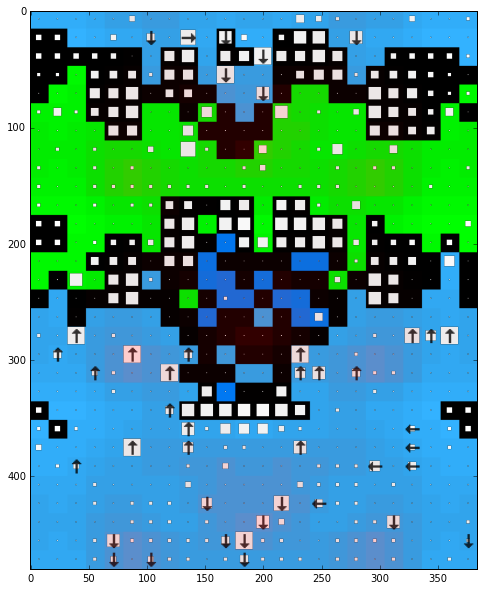

In [91]:
state = {
    'colors':frame[:,:,0],
    'heat':frame[:,:,2],
    'squares':frame[:,:,1],
    'arrows':moves2
}
plt.figure(figsize=(10,10))
ims = plot_ims(state)
plt.show()

In [70]:
wrap_shape[0]/2

25

In [72]:
np.arange(hstart,hend)

array([-2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
       15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27])

In [73]:
hstart

-2

In [74]:
hend

28